# Comparison Example for OSAR, DQN and C51 agents

In [1]:
!pip install ../../OSAR-keras/.

Processing /mnt/c/Users/ustyu/OneDrive/Projects/OSAR-keras
  Preparing metadata (setup.py) ... done
  Created wheel for OSAR-nightly: filename=OSAR_nightly-0.1.17.dev20220302-cp39-cp39-linux_x86_64.whl size=47907 sha256=53fcfcee5cc40f7635f3ba17528ce93ccd07c1a69eff74084f98d437c18de637
  Stored in directory: /home/constantine/.cache/pip/wheels/b0/55/4a/1bb4852a26744ba9735d506993c618d1ab7be56275314d8ea7
Successfully built OSAR-nightly
  Attempting uninstall: OSAR-nightly
    Found existing installation: OSAR-nightly 0.1.17.dev20220302
    Uninstalling OSAR-nightly-0.1.17.dev20220302:
      Successfully uninstalled OSAR-nightly-0.1.17.dev20220302


In [2]:
from __future__ import absolute_import, division, print_function

import base64
import imageio
import IPython
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import PIL.Image
import pyvirtualdisplay

import tensorflow as tf

from tf_agents import agents
from tf_agents.agents.dqn import dqn_agent
from tf_agents.drivers import dynamic_step_driver
from tf_agents.environments import suite_gym
from tf_agents.environments import tf_py_environment
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.networks import q_network
from tf_agents.policies import random_tf_policy
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.trajectories import trajectory
from tf_agents.utils import common
import pyvirtualdisplay

from OSAR import OSARQNetwork, Runner, DQNTrialAgent

print(tf.version.VERSION)

2.7.0


2022-03-02 23:19:27.888334: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:925] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-03-02 23:19:27.905843: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:925] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-03-02 23:19:27.906447: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:925] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-03-02 23:19:27.907766: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate

In [3]:
physical_devices = tf.config.list_physical_devices('GPU')
print("Num GPUs:", len(physical_devices))

Num GPUs: 1


In [4]:
num_iterations = 10000 # @param {type:"integer"}

initial_collect_steps = 100  # @param {type:"integer"} 
collect_steps_per_iteration = 1  # @param {type:"integer"}
replay_buffer_max_length = 1000  # @param {type:"integer"}

batch_size = 1  # @param {type:"integer"}
learning_rate = 1e-3  # @param {type:"number"}
log_interval = 20  # @param {type:"integer"}
memory_len = 10 # @param {type: "integer"}
n_turns = 3 # @param {type: "integer"}
num_atoms = 51  # @param {type:"integer"}
q_value = 20  # @param {type:"integer"}
n_step_update = 2  # @param {type:"integer"}

num_eval_episodes = 10  # @param {type:"integer"}
eval_interval = 1000  # @param {type:"integer"}

boltzmann_temperature = 10e-5 # @param {type:"float"}
epsilon_greedy = None # @param {type:"float"}
conv_type = '2d' # @param {type:"str"}

In [14]:
fc_layer_params = (10, 10)
from tf_agents.networks import q_network

osar_specs = {
    'batch_size': batch_size,
    'memory_len': memory_len,
    'n_turns': n_turns,
    'fc_layer_params': fc_layer_params,
    'num_atoms': num_atoms,
    'conv_type': conv_type,
    'learning_rate': learning_rate,
    'q_value': q_value,
    'n_step_update': n_step_update,
    'boltzmann_temperature': boltzmann_temperature,
    'epsilon_greedy': epsilon_greedy,
    'debug_summaries': True,
    'summarize_grads_and_vars': True,
}

def osar_generator(
    observation_spec,
    action_spec,
    batch_size,
    memory_len,
    n_turns,
    fc_layer_params,
    num_atoms,
    conv_type,
    learning_rate,
    time_step_spec,
    n_step_update=2,
    train_step_counter=tf.Variable(0, dtype=tf.int64),
    q_value=q_value,
    boltzmann_temperature=None,
    epsilon_greedy=0.1,
    debug_summaries=True,
    summarize_grads_and_vars=True,
    **kwargs,
    ):
    q_net = OSARQNetwork(
        observation_spec,
        action_spec,
        batch_size,
        memory_len,
        n_turns,
        fc_layer_params=fc_layer_params,
        conv_type=conv_type,
        )
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    
    agent = DQNTrialAgent(
        time_step_spec,
        action_spec,
        network=q_net,
        optimizer=optimizer,
        td_errors_loss_fn=common.element_wise_squared_loss,
        boltzmann_temperature=boltzmann_temperature,
        epsilon_greedy=epsilon_greedy,
        debug_summaries=debug_summaries,
        train_step_counter = train_step_counter,
        summarize_grads_and_vars=summarize_grads_and_vars,
    )
    
    agent.initialize()
    
    return agent

In [15]:
fc_layer_params = (64, 64)
from tf_agents.networks import categorical_q_network

c51_specs = {
    'batch_size': batch_size,
    'memory_len': memory_len,
    'fc_layer_params': fc_layer_params,
    'num_atoms': num_atoms,
    'conv_type': conv_type,
    'learning_rate': learning_rate,
    'q_value': q_value,
    'n_step_update': n_step_update,
    'boltzmann_temperature': boltzmann_temperature,
    'epsilon_greedy': epsilon_greedy,
    'debug_summaries': True,
    'summarize_grads_and_vars': True,
}
def c51_generator(
    observation_spec,
    action_spec,
    batch_size,
    memory_len,
    fc_layer_params,
    num_atoms,
    learning_rate,
    time_step_spec,
    n_step_update=2,
    conv_type='2d',
    train_step_counter=tf.Variable(0, dtype=tf.int64),
    q_value=q_value,
    boltzmann_temperature=None,
    epsilon_greedy=0.1,
    debug_summaries=True,
    summarize_grads_and_vars=True,
    ):

    q_net = categorical_q_network.CategoricalQNetwork(
    observation_spec,
    action_spec,
    num_atoms=num_atoms,
    fc_layer_params=fc_layer_params)
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    
    agent = agents.categorical_dqn.categorical_dqn_agent.CategoricalDqnAgent(
        time_step_spec,
        action_spec,
        categorical_q_network=q_net,
        optimizer=optimizer,
        td_errors_loss_fn=common.element_wise_squared_loss,
        train_step_counter = train_step_counter,
        min_q_value = -q_value,
        max_q_value = q_value,
        n_step_update = n_step_update,
        boltzmann_temperature=boltzmann_temperature,
        epsilon_greedy=epsilon_greedy,
        debug_summaries=debug_summaries,
        summarize_grads_and_vars=summarize_grads_and_vars,
    )
    agent.initialize()
    
    return agent

In [16]:
from tf_agents.environments.wrappers import PyEnvironmentBaseWrapper
from tf_agents.environments import py_environment
from tf_agents.trajectories import time_step as ts
class RewardRecordWrapper(PyEnvironmentBaseWrapper):
    """Clips reward to values of -1, 0, 1 and stores both."""

    def __init__(self, env: py_environment.PyEnvironment):
        """Creates a reward clip wrapper.
        Args:
        env: Environment to wrap.
        """
        super(RewardRecordWrapper, self).__init__(env)

        self.reward = []
        self.clipped_reward = []

    def _step(self, action):

        time_step = self._env.step(action)
        if not isinstance(time_step, tuple):
            done = time_step[2]
            if isinstance(time_step[-1], dict) and time_step[-1].get('time_remaining'):
                if time_step[-1].get('time_remaining') > 0:
                    step_type = StepType.MID
                elif time_step[-1].get('time_remaining') == 0 or done:
                    step_type = StepType.LAST
                else:
                    step_type = StepType.MID
            else:
                step_type = StepType.MID
            reward = tf.convert_to_tensor(time_step[1])
            discount = tf.convert_to_tensor(1.0)
            observation = time_step[0]
            meta = time_step[-1]
        else:
            step_type = time_step.step_type
            reward = time_step.reward
            discount = time_step.discount
            observation = time_step.observation
        self.reward.append(reward)

        return ts.TimeStep(
            step_type,
            reward,
            discount,
            observation)


In [17]:
from tf_agents.environments import suite_pybullet
from tf_agents.environments import suite_gym
from tf_agents.environments import tf_py_environment
start_env = suite_pybullet.load(
            'Alien-v0')
end_env = suite_pybullet.load(
            'BankHeist-v0')
train_env = tf_py_environment.TFPyEnvironment(start_env)
eval_env = tf_py_environment.TFPyEnvironment(start_env)

In [18]:
print(train_env.observation_spec(), train_env.action_spec())
print(end_env.observation_spec(), end_env.action_spec())

BoundedTensorSpec(shape=(210, 160, 3), dtype=tf.uint8, name='observation', minimum=array(0, dtype=uint8), maximum=array(255, dtype=uint8)) BoundedTensorSpec(shape=(), dtype=tf.int64, name='action', minimum=array(0), maximum=array(17))
BoundedArraySpec(shape=(210, 160, 3), dtype=dtype('uint8'), name='observation', minimum=0, maximum=255) BoundedArraySpec(shape=(), dtype=dtype('int64'), name='action', minimum=0, maximum=17)


In [20]:
# Phase One: training agent to solve the first game
osar_specs['train_step_counter'] = tf.Variable(0, dtype=tf.int64)
osar_specs['observation_spec'] = train_env.observation_spec()
osar_specs['action_spec'] = train_env.action_spec()
osar_specs['time_step_spec'] = train_env.time_step_spec()
agent = osar_generator(**osar_specs)

InvalidArgumentError: Exception encountered when calling layer "queue_memory" (type QueueMemory).

in user code:

    File "/home/constantine/miniconda3/envs/agents/lib/python3.9/site-packages/OSAR/queue_memory.py", line 128, in None  *
        lambda st: self._update(st, maximum_route, rewards)
    File "/home/constantine/miniconda3/envs/agents/lib/python3.9/site-packages/OSAR/queue_memory.py", line 135, in _update  *
        compatability_levels_by_queue = self._compute_compatability(
    File "/home/constantine/miniconda3/envs/agents/lib/python3.9/site-packages/OSAR/queue_memory.py", line 99, in _compute_compatability  *
        logit_substract = tf.tile(

    InvalidArgumentError: Expected multiples argument to be a vector of length 1 but got length 2 [Op:Tile]


Call arguments received:
  • inputs=['tf.Tensor(shape=(1, 24, 29), dtype=float32)', 'None']
  • frozen=3
  • kwargs={'training': 'False'}
  In call to configurable 'DQNTrialAgent' (<class 'OSAR.agent.DQNTrialAgent'>)

In [ ]:
c51_specs['train_step_counter'] = tf.Variable(0, dtype=tf.int64)
c51_specs['observation_spec'] = train_env.observation_spec()
c51_specs['action_spec'] = train_env.action_spec()
c51_specs['time_step_spec'] = start_env.time_step_spec()
agent = c51_generator(**c51_specs)

In [21]:
def compute_avg_return(environment, policy, num_episodes=10):

    total_return = 0.0
    for _ in range(num_episodes):

        time_step = environment.reset()
        episode_return = 0.0

        while not time_step.is_last():
            action_step = policy.action(time_step)
            time_step = environment.step(action_step.action)
            episode_return += time_step.reward
        total_return += episode_return

    avg_return = total_return / num_episodes
    return avg_return.numpy()[0]


random_policy = random_tf_policy.RandomTFPolicy(train_env.time_step_spec(),
                                                train_env.action_spec())

compute_avg_return(eval_env, random_policy, num_eval_episodes)

# Please also see the metrics module for standard implementations of different
# metrics.

172.0

In [58]:
replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=agent.collect_data_spec,
    batch_size=train_env.batch_size,
    max_length=replay_buffer_max_length)

def collect_step(environment, policy):
    time_step = environment.current_time_step()
    action_step = policy.action(time_step)
    next_time_step = environment.step(action_step.action)
    traj = trajectory.from_transition(time_step, action_step, next_time_step)

    # Add trajectory to the replay buffer
    replay_buffer.add_batch(traj)

for _ in range(initial_collect_steps):
    collect_step(train_env, random_policy)

# This loop is so common in RL, that we provide standard implementations of
# these. For more details see the drivers module.

# Dataset generates trajectories with shape [BxTx...] where
# T = n_step_update + 1.
dataset = replay_buffer.as_dataset(
    num_parallel_calls=3, sample_batch_size=batch_size,
    num_steps=n_step_update + 1).prefetch(3)

iterator = iter(dataset)

In [59]:
import tqdm
try:
    %%time
except:
    pass

# (Optional) Optimize by wrapping some of the code in a graph using TF function.
agent.train = common.function(agent.train)

# Reset the train step
agent.train_step_counter.assign(0)

# Evaluate the agent's policy once before training.
avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
returns = [avg_return]
with tqdm.trange(num_iterations) as t:
    for n_iter in t:

        if n_iter == num_iterations // 2:
            train_env = tf_py_environment.TFPyEnvironment(end_env)
            eval_env = tf_py_environment.TFPyEnvironment(end_env)

        # Collect a few steps using collect_policy and save to the replay buffer.
        for _ in range(collect_steps_per_iteration):
            collect_step(train_env, agent.collect_policy)

        # Sample a batch of data from the buffer and update the agent's network.
        experience, unused_info = next(iterator)

        train_loss = agent.train(experience)

        step = agent.train_step_counter.numpy()
        t.set_description(f'Episode {step}')
#         if step % log_interval == 0:
#             print('step = {0}: loss = {1}'.format(step, train_loss.loss))

        if step % eval_interval == 0:
            avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
#             print('step = {0}: Average Return = {1:.2f}'.format(step, avg_return))
        t.set_postfix(
            train_loss=train_loss.loss.numpy(), avg_return=avg_return)
        returns.append(avg_return)

Episode 10000: 100%|████████████████████████████| 10000/10000 [39:14<00:00,  4.25it/s, avg_return=0, train_loss=0.00425]


(-9.4, 550.0)

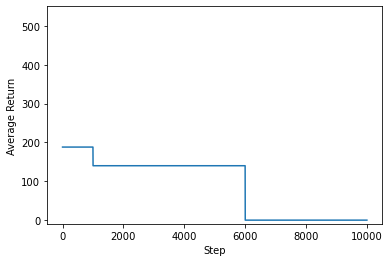

In [61]:
steps = range(0, num_iterations + 1, eval_interval)
plt.plot(returns)
plt.ylabel('Average Return')
plt.xlabel('Step')
plt.ylim(top=550)

In [62]:
def embed_mp4(filename):
      """Embeds an mp4 file in the notebook."""
      video = open(filename,'rb').read()
      b64 = base64.b64encode(video)
      tag = '''
      <video width="640" height="480" controls>
        <source src="data:video/mp4;base64,{0}" type="video/mp4">
      Your browser does not support the video tag.
      </video>'''.format(b64.decode())

      return IPython.display.HTML(tag)

In [66]:
# Set up a virtual display for rendering OpenAI gym environments.
display = pyvirtualdisplay.Display(visible=0, size=(1400, 900)).start()
    
num_episodes = 3
video_filename = 'imageio.mp4'
with imageio.get_writer(video_filename, fps=60) as video:
    for _ in range(num_episodes):
        time_step = eval_env.reset()
        video.append_data(eval_py_env.render())
        frames = 0
#         while not time_step.is_last():
        if frames < 36000:
            action_step = agent.policy.action(time_step)
            time_step = eval_env.step(action_step.action)
            video.append_data(eval_py_env.render())
            frames += 1

embed_mp4(video_filename)

KeyboardInterrupt: 